# Interesa Rate Curve construction: Bootstrap method

From "Options, Futures, and Other Derivatives", Pearon, 9th Edition, Prof. John Hull (pages 106-108).

Let's buils a zero rates curve with the bootstrap method, using Treasury bills and coupon-bearing bonds.

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import math as m

In [2]:
# Import Bonds data

bonds = pd.read_csv('Bonds.csv')
bonds

,Bond principal,Term,AnnualCouponAmnt,Bond price,Annual coupons
0,100,0.25,0,97.5,0
1,100,0.50,0,94.9,0
2,100,1.00,0,90.0,0
3,100,1.50,8,96.0,2
4,100,2.00,12,101.6,2


For the first 3 bonds, the rate can be caslculated easily.

Then the coupon-bearing bonds, we can bootstrap the previously calculated rates for the intermediate payments.

In [3]:
# For each bond, well add a new rate to the IR curve (bootstrap_zerorates df)

In [4]:
# Let's start the code by defining a function that will create a numpy array
# with a column for each payment (cash flow) of the bond.

def create_bond_cf(coupons_peryear = 0, term = 0):
    if term <= 1:
        payments = 1
    else:
        payments = int( coupons_peryear * float(term) )
    
    bond_cf = np.empty( payments )
    
    return bond_cf

In [5]:
# Let's also define a function that will calculate the continous rate based on the bond price, principal and time.
# the formula is designed to work bond with a single payment, but data can be adjusted for bonds with more cash flows.

def bond_rate(price, ppal, time):
    rate = - m.log( price / ppal ) / time
    return rate

In [6]:
# To build the IR curve, we'll calculate one rate per bond in the DataFrame

In [7]:
# Now we will define the zero rate curve (bootstrap_zerorates)

bootstrap_zerorates = pd.DataFrame( {'maturity': [], 'rate': [] } )


# Then we need to iterate through each of the bonds to calculate the rate for each term

for bond in range( bonds.shape[0] ):
    
    # create a numpy array with an element for each cash flow
    bond_cf = create_bond_cf(coupons_peryear = bonds.loc[ bond , 'Annual coupons'] , term = bonds.loc[ bond , 'Term'] )
    
    if len(bond_cf) == 1:
        # for bonds with one single payment
        calculated_rate = bond_rate(price = bonds.loc[ bond , 'Bond price'],
                                    ppal = bonds.loc[ bond , 'Bond principal'],
                                    time = bonds.loc[ bond , 'Term'])
    else:
        # for bonds with multiple payments (coupons & principal)
        payments = 0
        coupon_amount = bonds.loc[ bond , 'AnnualCouponAmnt'] / bonds.loc[ bond , 'Annual coupons']

        for i in range( len(bond_cf)-1 ):
            coupon_term = (i+1)/2
            int_rate = bootstrap_zerorates.loc[ bootstrap_zerorates['maturity'] == coupon_term, 'rate']
            
            # calculate current (discounted) value of payments (coupons) with already calculated rates
            payments += coupon_amount * m.exp( - int_rate * coupon_term)
            
            # we'll use the bond_rate() function with an adjusment of the variables
            # price: bond price - payments
            # principal: principal + coupon amount, given the last cash flow includes both (term to calculate)
            
        calculated_rate = bond_rate(price = bonds.loc[ bond , 'Bond price'] - payments,
                                    ppal = bonds.loc[ bond , 'Bond principal'] + coupon_amount,
                                    time = bonds.loc[ bond , 'Term'])
            
    
    # add recently calculated rate to the rates curve df
    maturity = bonds.loc[ bond , 'Term']
    
    new_rate = {'maturity': maturity, 'rate': calculated_rate }
    
    bootstrap_zerorates = bootstrap_zerorates.append(new_rate, ignore_index=True)

bootstrap_zerorates

,maturity,rate
0,0.25,0.101271
1,0.50,0.104693
2,1.00,0.105361
3,1.50,0.106809
4,2.00,0.108080


In [8]:
# Given it's assumed that the zero curve is horizontal prior to the first point, and also,
# that it's horizontal beyond the last point

# Adding rate for term 0
calc_maturity = 0

min_maturity = min( bootstrap_zerorates['maturity'] )

min_mat_rate = bootstrap_zerorates.loc[ bootstrap_zerorates['maturity'] == min_maturity, 'rate' ].to_numpy()[0]
min_mat_rate

new_rate = {'maturity': calc_maturity, 'rate': min_mat_rate }

bootstrap_zerorates = bootstrap_zerorates.append(new_rate, ignore_index=True)


# Adding rate for term 3 (so the plot later ends in term equal to 3 years)
calc_maturity = 3

max_maturity = max( bootstrap_zerorates['maturity'] )

max_mat_rate = bootstrap_zerorates.loc[ bootstrap_zerorates['maturity'] == max_maturity, 'rate' ].to_numpy()[0]
max_mat_rate

new_rate = {'maturity': calc_maturity, 'rate': max_mat_rate }

bootstrap_zerorates = bootstrap_zerorates.append(new_rate, ignore_index=True)

bootstrap_zerorates

,maturity,rate
0,0.25,0.101271
1,0.50,0.104693
2,1.00,0.105361
3,1.50,0.106809
4,2.00,0.108080
5,0.00,0.101271
6,3.00,0.108080


In [9]:
# Before plotting, let's order the rates based on maturity

bootstrap_zerorates = bootstrap_zerorates.sort_values(by='maturity')
bootstrap_zerorates

,maturity,rate
5,0.00,0.101271
0,0.25,0.101271
1,0.50,0.104693
2,1.00,0.105361
3,1.50,0.106809
4,2.00,0.108080
6,3.00,0.108080


# Plotting

In [10]:
# Importing matplotlib to generate the line plot

import matplotlib.pyplot as plt

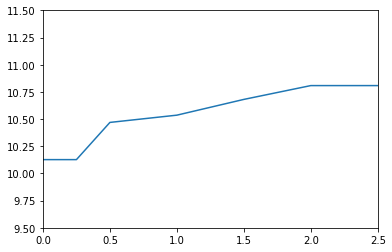

In [11]:
# plot (rate multiplied by 100)
plt.plot( bootstrap_zerorates['maturity'], bootstrap_zerorates['rate']*100 )

# fixing the X and Y limits so the plot looks better
plt.xlim([0, 2.5])
plt.ylim([9.5, 11.5])

plt.show()